# Model 6: Vertical and horizontal cultural transmission

### Note

- One obvious difference between cultural and genetic evolution is in their pathways of transmission.
    - In genetic evolution, we get our genes exclusively from our two biological parents.
    - In cultural evolution, we get cultural traits from a wide array of sources.
- Model 1 〜 5 are oblique cultural transmission.
- In Model 6 we will consider
    - vertical cultural transmission, in which agents learn from two parents, and
    - horizontal cultural transmission, where agents learn from members of the same generation.

## Model 6a: Vertical cultural transmission

In [1]:
include("src/Agent.jl")
include("src/Output.jl")
using .Agent
using .Output

using Random

In [2]:
make_agent_df = Agent.make_agent_AB_df;

In [3]:
function get_new_trait(father::Agent.Trait, mother::Agent.Trait, s_v::Float64)::Agent.Trait
    # 次のTraitがAになる確率
    prob = if father == A && mother == A
        1.0
    elseif (father == A && mother == B) || (father == B && mother == A)
        1 / 2 + s_v / 2
    elseif father == B && mother == B
        0.0
    end

    return prob > rand() ? A : B
end

function vertical_transmission(; N::Int64, r_max::Int64, t_max::Int64, p_0::Float64, s_v::Float64)
    output_df = make_output_df(r_max, t_max)

    for r = 1:r_max
        agent_df = make_agent_df(N, p_0)

        for t = 1:t_max
            if t > 1
                fathers = shuffle(agent_df.trait)
                mothers = shuffle(agent_df.trait)
                agent_df.trait = [get_new_trait(father, mother, s_v) for (father, mother) in zip(fathers, mothers)]
            end

            # get p and put it into the output slot for this generation t
            row_num = t + (r - 1) * t_max
            output_df.r[row_num] = r
            output_df.t[row_num] = t
            output_df.p[row_num] = trait_ratio(agent_df, A)
        end
    end
    
    plot_A(output_df, "N = $N, p_0 = $p_0, s_v = $s_v")
end;

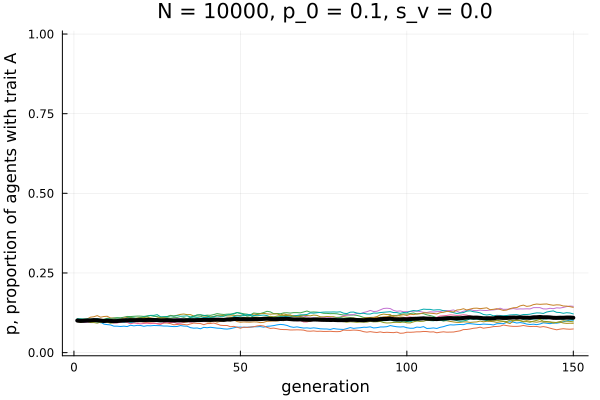

In [4]:
vertical_transmission(N = 10^4, r_max = 10, t_max = 150, p_0 = 0.1, s_v = 0.0)

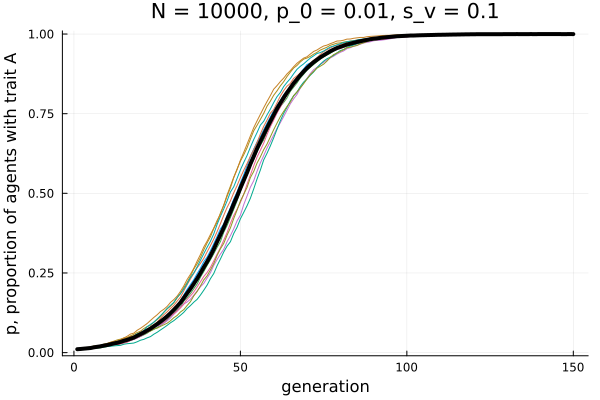

In [5]:
vertical_transmission(N = 10^4, r_max = 10, t_max = 150, p_0 = 0.01, s_v = 0.1)

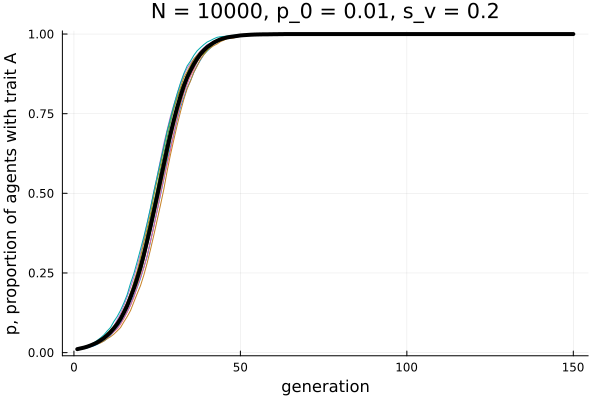

In [6]:
vertical_transmission(N = 10^4, r_max = 10, t_max = 150, p_0 = 0.01, s_v = 0.2)

### Note

- 結果は、[Model 3: Biased transmission (direct / content bias)](https://github.com/mas178/social-simulation/blob/main/Mesoudi2021/model03_biased_transmission_direct_content_bias.ipynb) によく似ている。
- Model 3 が1人の親からTraitを受け継ぐのに対して、Model 6 は2人の親からTraitを受け継いでいると見做せる。

## Model 6b: Assortative mating (同類交配)

### Note

- In reality, parents may be more culturally similar than average.
- In evolutionary biology, this is known as **assortative mating (同類交配)**.

In [7]:
function vertical_transmission(; N::Int64, r_max::Int64, t_max::Int64, p_0::Float64, s_v::Float64, a::Float64)
    output_df = make_output_df(r_max, t_max)

    for r = 1:r_max
        agent_df = make_agent_df(N, p_0)

        for t = 1:t_max
            if t > 1
                mothers = shuffle(agent_df.trait)
                fathers = [a > rand() ? mother : rand(agent_df.trait) for mother in mothers]
                agent_df.trait = [get_new_trait(father, mother, s_v) for (father, mother) in zip(fathers, mothers)]
            end

            # get p and put it into the output slot for this generation t
            row_num = t + (r - 1) * t_max
            output_df.r[row_num] = r
            output_df.t[row_num] = t
            output_df.p[row_num] = trait_ratio(agent_df, A)
        end
    end

    plot_A(output_df, "N = $N, p_0 = $p_0, s_v = $s_v, a = $a")
end;

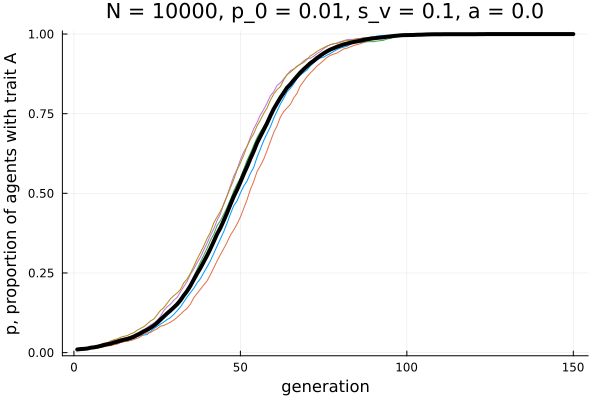

In [8]:
vertical_transmission(N = 10^4, r_max = 5, t_max = 150, p_0 = 0.01, s_v = 0.1, a = 0.0)

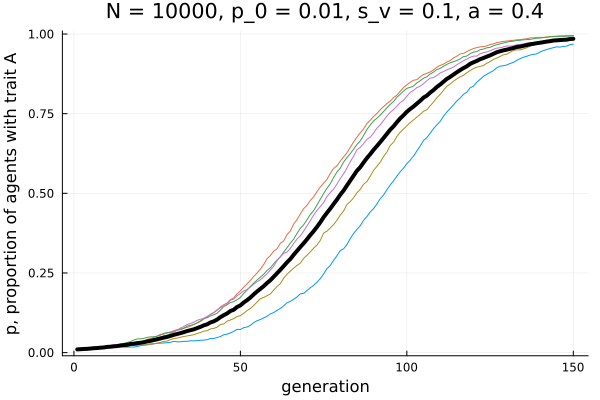

In [9]:
vertical_transmission(N = 10^4, r_max = 5, t_max = 150, p_0 = 0.01, s_v = 0.1, a = 0.4)

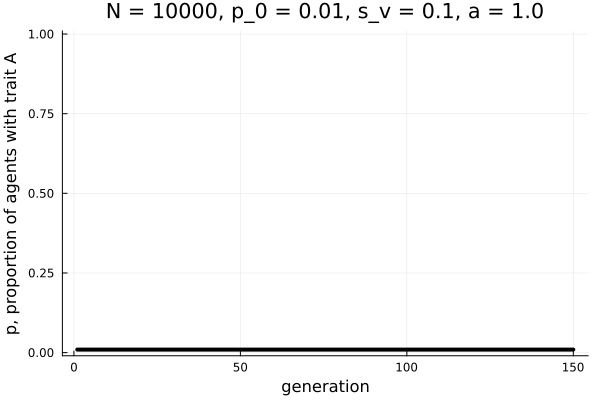

In [10]:
vertical_transmission(N = 10^4, r_max = 5, t_max = 150, p_0 = 0.01, s_v = 0.1, a = 1.0)

### Note

- Complete assortative mating results in no cultural change, beyond random fluctuations, even when selection is acting.
- In general, the more assortative mating there is, the weaker cultural selection will be.

## Model 6c: Horizontal cultural transmission

### Note

- There are many ways of implementing horizontal cultural transmission.
- To allow a comparison with vertical transmission, here we will assume directly biased horizontal transmission.
- In Model 6c we assume that agents now choose $n$ members of the same generation, i.e. the set of agents who have already undergone vertical transmission.
- If at least one of those $n$ demonstrators has trait $A$, then the learner adopts trait $A$ with probability $s_h$.

In [11]:
function vertical_horizontal_transmission(; N::Int64, r_max::Int64, t_max::Int64, p_0::Float64, s_v::Float64, s_h::Float64, a::Float64, n::Int64)
    output_df = make_output_df(r_max, t_max)

    for r = 1:r_max
        agent_df = make_agent_df(N, p_0)

        for t = 1:t_max
            if t > 1
                # 1. assortative mating:
                mothers = shuffle(agent_df.trait)
                fathers = [a > rand() ? mother : rand(agent_df.trait) for mother in mothers]
                
                # 2. vertical transmission:
                agent_df.trait = [get_new_trait(father, mother, s_v) for (father, mother) in zip(fathers, mothers)]
                
                # 3. horizontal transmission:
                demonstrators = rand(agent_df.trait, (N, n))
                oneA = [count(d .== A) >= 1 for d in eachrow(demonstrators)]
                agent_df.trait = [(one_a && s_h > rand()) ? A : t for (t, one_a) in zip(agent_df.trait, oneA)]
            end

            # get p and put it into the output slot for this generation t
            row_num = t + (r - 1) * t_max
            output_df.r[row_num] = r
            output_df.t[row_num] = t
            output_df.p[row_num] = trait_ratio(agent_df, A)
        end
    end
    
    plot_A(output_df, "N = $N, p_0 = $p_0, s_v = $s_v, s_h = $s_h, a = $a, n = $n")
end;

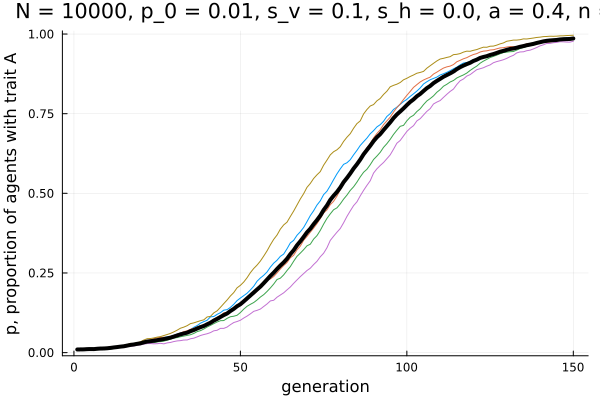

In [12]:
vertical_horizontal_transmission(N = 10^4, r_max = 5, t_max = 150, p_0 = 0.01, s_v = 0.1, s_h = 0.0, a = 0.4, n = 0)

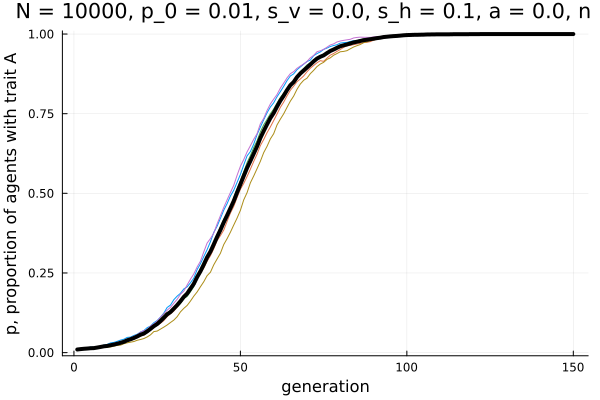

In [13]:
vertical_horizontal_transmission(N = 10^4, r_max = 5, t_max = 150, p_0 = 0.01, s_v = 0.0, s_h = 0.1, a = 0.0, n = 1)

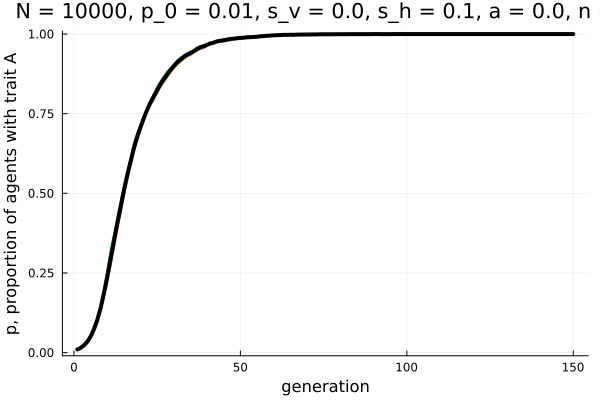

In [14]:
vertical_horizontal_transmission(N = 10^4, r_max = 5, t_max = 150, p_0 = 0.01, s_v = 0.0, s_h = 0.1, a = 0.0, n = 5)

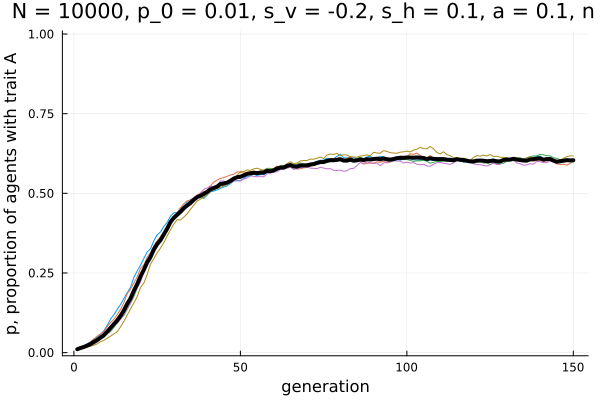

In [15]:
vertical_horizontal_transmission(N = 10^4, r_max = 5, t_max = 150, p_0 = 0.01, s_v = -0.2, s_h = 0.1, a = 0.1, n = 5)

# Recap of Model 01 〜 06

- Transmission (伝達)
    - Oblique (斜めの伝達): 親以外の前世代からも特性を受け継ぐ。
        - Unbiased ([Model 1](https://github.com/mas178/social-simulation/blob/main/Mesoudi2021/model01_unbiased_transmission.ipynb)): 集団の中からランダムに個体を選択して、その特性を引き継ぐ。特性分布は、初期特性分布に等しくなる。
        - Biased
            - Direct / content bias (Model 3): 直接 Trait が伝播しやすさに紐付いている。
            - Indirect bias (Model 4): Trait 以外の属性 (ペイオフ、年齢、ジェンダー、社会階層 など) が、伝播しやすさに紐付いている。
            - Conformist bias (同調バイアス) (Model 5): 多数派のTraitを真似する。
    - Vertical and Horizontal (垂直伝達と水平伝達) (Model 6)
- Mutation (変異) ([Model 2](https://github.com/mas178/social-simulation/blob/main/Mesoudi2021/model02_unbiased_and_biased_mutation.ipynb))
    - Unbiased: 前世代から特性をコピーする際に、一定の確率でエラーが生じる。文化特性の分布は、初期分布に関わらず、$\frac{1}{n}$に収束する。但し、$n$ は特性の数。
    - Biased: 前世代から特性をコピーする際に、一定の確率でエラーが生じる。但し、特性Bから特性Aへのエラーは生じるが、逆は生じないとする。特性Aの分布は、初期分布に関わらず、1.0 に収束する。